## Part 1: Regularized Regression Methods

In [147]:
#Import useful libraries
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
%matplotlib inline

### 1.1: Data Cleaning, EDA 

In [148]:
train = pd.read_csv("housing_train.csv")
test = pd.read_csv("housing_test.csv")

train.columns = train.columns.str.replace(' ', '')
test.columns = test.columns.str.replace(' ', '')

In [149]:
#Check that data loaded correctly
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [151]:
#Save ID Column
train_ID = train['Id']
test_ID = test['Id']

#Drop ID column for prediction
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [152]:
#Create training and validation data sets
np.random.seed(42)

Y = train["SalePrice"]
X = train.drop("SalePrice",axis=1)

#Split data into training and validation sets using sklearn with an 80/20 split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, random_state=42)

In the last assignment, we focused on 12 features to base predictions on: "OverallQual", "GrLivArea", "GarageArea", "YearRemodAdd", "FullBath", "YearBuilt", "1stFlrSF", "Neighborhood","OverallCond", "BsmtFinType1", "HouseStyle", "SaleCondition". 

Let's double check to see if we should keep these features or add/replace them with additional features not used in the assignment 1 analysis

In [153]:
#In assignment 1 correlations were determined using Pearson's coeff with the the following identified as important features
copy = X_train.copy()
copy["SalePrice"] = Y_train.astype(float)
copy.corr()["SalePrice"].sort_values(ascending=False).head(11)

SalePrice       1.000000
OverallQual     0.785555
GrLivArea       0.695652
GarageCars      0.640991
GarageArea      0.624139
TotalBsmtSF     0.597766
1stFlrSF        0.587883
FullBath        0.552546
TotRmsAbvGrd    0.520388
YearBuilt       0.516501
YearRemodAdd    0.508593
Name: SalePrice, dtype: float64

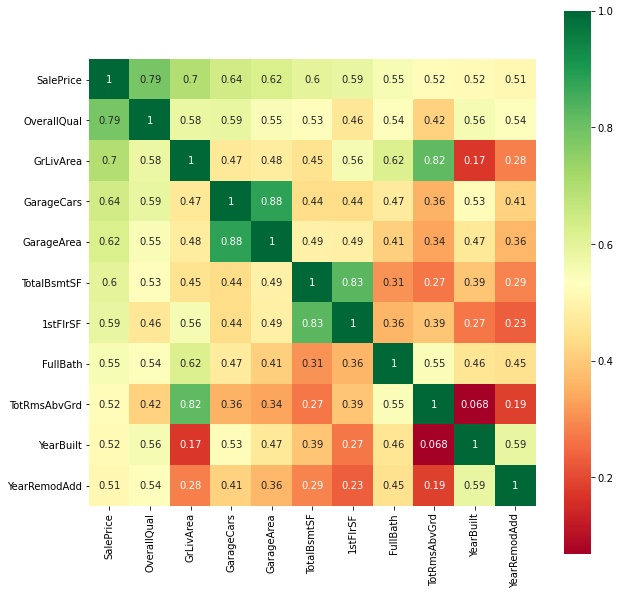

In [154]:
#With corresponding corr matrix:
fig, ax = plt.subplots(figsize=(10, 10))
corr_matrix = copy.corr()
cols = corr_matrix.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(copy[cols].values.T)
sns.heatmap(cm, cbar=True, cmap='RdYlGn', annot=True, square=True, yticklabels=cols.values, xticklabels=cols.values)

Pearson's coefficient evaluates linear relationships between continuous variables. We note that some of these features are configured as ranked choice (OverallQual, GarageCars). With these types of variables it is preferred to use Spearman's Correlation coefficient because it can detect nonlinear relationships and works better for ranking-type data. 

In [155]:
copy.corr(method='spearman')["SalePrice"].sort_values(ascending=False).head(11)

SalePrice       1.000000
OverallQual     0.801016
GrLivArea       0.723435
GarageCars      0.686763
YearBuilt       0.643216
GarageArea      0.638676
FullBath        0.625567
TotalBsmtSF     0.595014
GarageYrBlt     0.581821
1stFlrSF        0.566305
YearRemodAdd    0.562948
Name: SalePrice, dtype: float64

Some of the coefficient values have changed but the identified features remain the same between the two types of coefficients. 
For assignment 1, categorical features were chosen based on intuition considering the condition of the home.

In this assignment we will try a different approach. Instead of selecting a few variables, the entire dataset will be cleaned up as much as possible and used for analysis. We will see if this approach gives better results given the lowered risk of data loss associated with removing variables. 

,Count,Percent
PoolQC,1162,79.589041
MiscFeature,1122,76.849315
Alley,1094,74.931507
Fence,935,64.041096
FireplaceQu,547,37.465753
LotFrontage,217,14.863014
GarageType,64,4.383562
GarageYrBlt,64,4.383562
GarageFinish,64,4.383562
GarageQual,64,4.383562


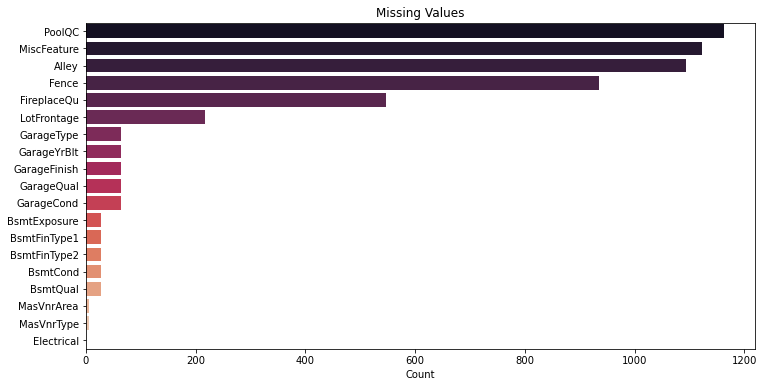

In [156]:
#Our first step is to deal with any missing values
missing_data_count = X_train.isnull().sum()
missing_data_percent = X_train.isnull().sum() / len(X) * 100

missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(y=missing_data.index,
            x=missing_data.Count,
            palette="rocket")
title = plt.title("Missing Values")
missing_data

Missing values for most of these features indicate an absence of that given feature. If the feature is categorical, we will replace the NA values with "None". If the feature is numeric the NA will be replaced with a 0. 

Three variables that stand out are LotFrontage, GarageYrBlt. Instead of replacing these with 0's we will replace the NAs of GarageYrBlt with the year the home was built and the NAs of LotFrontage with the median of lot frontage grouped by neighborhood. This will probably give a more representative result than replacing these values with 0.

In [157]:
#Replace categorical NAs with None
cat_missing = [ 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Electrical','MSZoning',
    'Functional','Utilities','SaleType','Exterior1st','Exterior2nd','KitchenQual']
X_train[cat_missing] = X_train[cat_missing].fillna("None")
X_val[cat_missing] = X_val[cat_missing].fillna("None")
test[cat_missing] = test[cat_missing].fillna("None")

#Replace numeric NAs with 0
num_missing = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
X_train[num_missing] = X_train[num_missing].fillna(0)
X_val[num_missing] = X_val[num_missing].fillna(0)
test[num_missing] = test[num_missing].fillna(0)

#LotFrontage and GarageYrBlt
X_train["LotFrontage"] = X_train["LotFrontage"].fillna(X_train["LotFrontage"].mean())
X_train["GarageYrBlt"] = X_train["GarageYrBlt"].fillna(X_train["YearBuilt"])

X_val["LotFrontage"] = X_val["LotFrontage"].fillna(X_val["LotFrontage"].mean())
X_val["GarageYrBlt"] = X_val["GarageYrBlt"].fillna(X_val["YearBuilt"])

test["LotFrontage"] = test["LotFrontage"].fillna(test["LotFrontage"].mean())
test["GarageYrBlt"] = test["GarageYrBlt"].fillna(test["YearBuilt"])

In [158]:
#Check if missing values are gone
print(X_train.isna().values.any())
print(X_val.isna().values.any())
print(test.isna().values.any())

False
False
False


In [159]:
#Separate dataset into categorical and numeric features
Xtrain_num = X_train.select_dtypes(include=["float","int64"]).columns
Xtrain_cat = X_train.select_dtypes(include=["object"]).columns

Xval_num = X_val.select_dtypes(include=["float","int64"]).columns
Xval_cat = X_val.select_dtypes(include=["object"]).columns

test_num = test.select_dtypes(include=["float","int64"]).columns
test_cat = test.select_dtypes(include=["object"]).columns

In [160]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

#Use Column transformer to perform scaling for numeric variables and one-hot encoding for categorical variables
ct = ColumnTransformer(
    transformers=
    [('standardized',numeric_transformer,Xtrain_num),
       ('oneHotter', categorical_transformer,Xtrain_cat)])


From assignment 1, we saw that the target variable was skewed. We want to again perform a log transformation on SalePrice to give the target variable a normal distribution shape

Skewness: 0.124880
Kurtosis: 0.700245


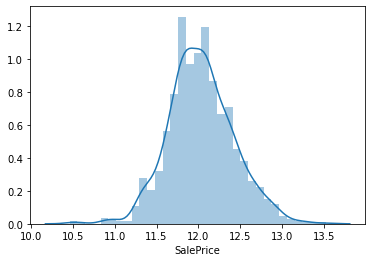

In [161]:
y = np.log(Y_train)
sns.distplot(y)
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 0.144873
Kurtosis: 1.050142


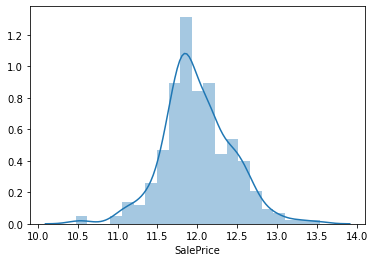

In [162]:
#Perform the same log transformation on the validation set
y_val = np.log(Y_val)
sns.distplot(y_val)
print("Skewness: %f" % y_val.skew())
print("Kurtosis: %f" % y_val.kurt())

In [163]:
#Lets check some of our features for high skew values (>0.75)
skewness = X_train.skew().sort_values(ascending=False)
skewness[abs(skewness) > 0.75]

MiscVal          22.053579
PoolArea         14.396098
LotArea          11.958088
3SsnPorch         9.833911
LowQualFinSF      9.199456
KitchenAbvGr      4.445055
BsmtFinSF2        4.217895
ScreenPorch       4.090393
BsmtHalfBath      4.005786
EnclosedPorch     3.163946
LotFrontage       2.666498
OpenPorchSF       2.331890
MasVnrArea        2.294117
BsmtFinSF1        1.862132
TotalBsmtSF       1.723881
WoodDeckSF        1.587330
MSSubClass        1.438804
GrLivArea         1.425139
1stFlrSF          1.422162
BsmtUnfSF         0.910628
2ndFlrSF          0.801209
dtype: float64

In [164]:
#We can perform a log transformation on these columns as well 
#Remove MSSubClass/KitchenAbvGr/BsmtHalfBath because they are not a continuous numeric)
skewed_cols = list(skewness[abs(skewness) > 0.75].index)

skewed_cols = [
    col for col in skewed_cols if col not in ['MSSubClass', 'KitchenAbvGr', 'BsmtHalfBath']
]

for col in skewed_cols:
    X_train[col] = np.log(1 + X_train[col])
    X_val[col] = np.log(1 + X_val[col])
    test[col] = np.log(1 + test[col])

In [165]:
#check skew values
X_train[skewed_cols].skew().sort_values(ascending=False)

PoolArea         13.874124
3SsnPorch         7.510573
LowQualFinSF      7.447547
MiscVal           5.004489
ScreenPorch       3.062578
BsmtFinSF2        2.561997
EnclosedPorch     2.179302
MasVnrArea        0.452588
2ndFlrSF          0.268476
WoodDeckSF        0.181798
1stFlrSF          0.026976
GrLivArea         0.007943
LotArea          -0.012599
OpenPorchSF      -0.064149
BsmtFinSF1       -0.622601
LotFrontage      -0.821789
BsmtUnfSF        -2.188927
TotalBsmtSF      -5.274632
dtype: float64

Still a few high values but overall there should be an improvement.

## 1.2: Model Training, Evaluation, and Comparison

In [166]:
#We are going to use K-fold validation with 10 folds
kf=KFold(n_splits=10)

#Alpha values for hyperparameter testing
alphas=[0.001,0.01,0.1,1.0,10,100]

### Ridge Regression

In [167]:
#Use the processing loop from the getting started notebook
#This will perform the transformations and model fitting within each fold

resListofDicts=[]                        # a list of results in dicts
for alphVal in alphas:  # Outer processing loop
    fold = 0            # fold counter
    for trainNdx, testNdx in kf.split(X_train): # cv loop. should do it 10 times.
        fold+=1
        Xtr = ct.fit_transform(X_train.iloc[trainNdx])   # fit and transform X training fold
        Xval = ct.transform(X_train.iloc[testNdx])       # transform X test fold
        regMod=Ridge(alpha=alphVal)  # instantiate regressor
        fitMod=regMod.fit(Xtr,y.iloc[trainNdx])           # fitted
        predtr = fitMod.predict(Xtr)             # training pred values
        predval = fitMod.predict(Xval)           # test pred values
        msetr = metrics.mean_squared_error(y.iloc[trainNdx],predtr)
        mseval = metrics.mean_squared_error(y.iloc[testNdx],predval)
        resDict={'alpha': alphVal,'fold': fold,
                'trainMSE':msetr,'testMSE':mseval}
        resListofDicts.append(resDict)

In [168]:
resultsDF=pd.DataFrame(resListofDicts)
resultsDF.shape
resultsDF.columns

Index(['alpha', 'fold', 'trainMSE', 'testMSE'], dtype='object')

In [169]:
#View results to see which alpha value has the lowest mean MSE for the test data
resultsSummaryDF=resultsDF.groupby(['alpha'],as_index=False).agg({'trainMSE':['mean','std'],'testMSE':['mean','std']})
resultsSummaryDF

alpha  trainMSE             testMSE          
                mean       std      mean       std
0    0.001  0.007632  0.000383  0.021459  0.010698
1    0.010  0.007626  0.000399  0.021371  0.010663
2    0.100  0.007715  0.000381  0.020277  0.010288
3    1.000  0.008343  0.000398  0.018443  0.009712
4   10.000  0.010401  0.000562  0.017471  0.009172
5  100.000  0.013795  0.000774  0.018002  0.009144

It looks like an alpha value of 10 gives the lowest mean MSE for the test data. We will now refit a Ridge Regression Model with an alpha=10. 

In [170]:
#Save transformed data
X_final = ct.fit_transform(X_train)
X_final_val = ct.transform(X_val)
test_final = ct.transform(test)
print(X_final.shape)
print(X_final_val.shape)
print(test.shape)

(1168, 301)
(292, 301)
(1459, 79)


In [71]:
#Fit and Predictions for Ridge Model
Ridge_model = Ridge(alpha=10)
Ridge_model.fit(X_final,y)

Ridge_predictions = Ridge_model.predict(X_final)
Ridge_predictions_val = Ridge_model.predict(X_final_val)

Ridge_R_squared = Ridge_model.score(X_final,y)
Ridge_R_squared_val = Ridge_model.score(X_final_val,y_val)

print(f'R-Squared for Ridge Regression (Training): {Ridge_R_squared.round(3)}')
print(f'R-Squared for Ridge Regression (Validation): {Ridge_R_squared_val.round(3)}')

R-Squared for Ridge Regression (Training): 0.93
R-Squared for Ridge Regression (Validation): 0.909


### Lasso Regression

In [72]:
resListofDicts=[]                        # a list of results in dicts
for alphVal in alphas:  # Outer processing loop
    fold = 0            # fold counter
    for trainNdx, testNdx in kf.split(X_train): # cv loop. should do it 10 times.
        fold+=1
        Xtr = ct.fit_transform(X_train.iloc[trainNdx])   # fit and transform X training fold
        Xval = ct.transform(X_train.iloc[testNdx])       # transform X test fold
        regMod=Lasso(alpha=alphVal)  # instantiate regressor
        fitMod=regMod.fit(Xtr,y.iloc[trainNdx])           # fitted
        predtr = fitMod.predict(Xtr)             # training pred values
        predval = fitMod.predict(Xval)           # test pred values
        msetr = metrics.mean_squared_error(y.iloc[trainNdx],predtr)
        mseval = metrics.mean_squared_error(y.iloc[testNdx],predval)
        resDict={'alpha': alphVal,'fold': fold,
                'trainMSE':msetr,'testMSE':mseval}
        resListofDicts.append(resDict)

In [73]:
resultsDF=pd.DataFrame(resListofDicts)
resultsDF.shape
resultsDF.columns

Index(['alpha', 'fold', 'trainMSE', 'testMSE'], dtype='object')

In [74]:
#View results to see which alpha value has the lowest mean MSE for the test data
resultsSummaryDF=resultsDF.groupby(['alpha'],as_index=False).agg({'trainMSE':['mean','std'],'testMSE':['mean','std']})
resultsSummaryDF

alpha  trainMSE             testMSE          
                mean       std      mean       std
0    0.001  0.012447  0.000690  0.017096  0.009139
1    0.010  0.019002  0.000914  0.020668  0.008600
2    0.100  0.045974  0.000970  0.046775  0.012980
3    1.000  0.152432  0.003721  0.152624  0.033504
4   10.000  0.152432  0.003721  0.152624  0.033504
5  100.000  0.152432  0.003721  0.152624  0.033504

In [75]:
#Fit and Predictions for Lasso Model
#Alpha value for lasso is 0.001

Lasso_model = Lasso(alpha=0.001)
Lasso_model.fit(X_final,y)

Lasso_predictions = Lasso_model.predict(X_final)
Lasso_predictions_val = Lasso_model.predict(X_final_val)

Lasso_R_squared = Lasso_model.score(X_final,y)
Lasso_R_squared_val = Lasso_model.score(X_final_val,y_val)

print(f'R-Squared for Lasso Regression (Training): {Lasso_R_squared.round(3)}')
print(f'R-Squared for Lasso Regression (Validation): {Lasso_R_squared_val.round(3)}')

R-Squared for Lasso Regression (Training): 0.916
R-Squared for Lasso Regression (Validation): 0.906


### ElasticNet Regression

In [76]:
resListofDicts=[]                        # a list of results in dicts
for alphVal in alphas:  # Outer processing loop
    fold = 0            # fold counter
    for trainNdx, testNdx in kf.split(X_train): # cv loop. should do it 10 times.
        fold+=1
        Xtr = ct.fit_transform(X_train.iloc[trainNdx])   # fit and transform X training fold
        Xval = ct.transform(X_train.iloc[testNdx])       # transform X test fold
        regMod=ElasticNet(alpha=alphVal)  # instantiate regressor
        fitMod=regMod.fit(Xtr,y.iloc[trainNdx])           # fitted
        predtr = fitMod.predict(Xtr)             # training pred values
        predval = fitMod.predict(Xval)           # test pred values
        msetr = metrics.mean_squared_error(y.iloc[trainNdx],predtr)
        mseval = metrics.mean_squared_error(y.iloc[testNdx],predval)
        resDict={'alpha': alphVal,'fold': fold,
                'trainMSE':msetr,'testMSE':mseval}
        resListofDicts.append(resDict)

In [77]:
resultsDF=pd.DataFrame(resListofDicts)
resultsDF.shape
resultsDF.columns

Index(['alpha', 'fold', 'trainMSE', 'testMSE'], dtype='object')

In [78]:
#View results to see which alpha value has the lowest mean MSE for the test data
resultsSummaryDF=resultsDF.groupby(['alpha'],as_index=False).agg({'trainMSE':['mean','std'],'testMSE':['mean','std']})
resultsSummaryDF

alpha  trainMSE             testMSE          
                mean       std      mean       std
0    0.001  0.010576  0.000459  0.017053  0.009212
1    0.010  0.017321  0.000907  0.019669  0.008876
2    0.100  0.029473  0.000855  0.030541  0.009341
3    1.000  0.152432  0.003721  0.152624  0.033504
4   10.000  0.152432  0.003721  0.152624  0.033504
5  100.000  0.152432  0.003721  0.152624  0.033504

In [79]:
#Fit and Predictions for ElasticNet Model
#Alpha value for ElasticNet is 0.001

E_model = ElasticNet(alpha=0.001)
E_model.fit(X_final,y)

E_predictions = E_model.predict(X_final)
E_predictions_val = E_model.predict(X_final_val)

E_R_squared = E_model.score(X_final,y)
E_R_squared_val = E_model.score(X_final_val,y_val)

print(f'R-Squared for ElasticNet Regression (Training): {E_R_squared.round(3)}')
print(f'R-Squared for ElasticNet Regression (Validation): {E_R_squared_val.round(3)}')

R-Squared for ElasticNet Regression (Training): 0.928
R-Squared for ElasticNet Regression (Validation): 0.914


## 1.3: Improve ElasticNet

We will try to improve the ElasticNet Model by performing hyperparameter tuning for the L1 ratio as well as the alpha values.

In [83]:
from sklearn.model_selection import GridSearchCV
grid_param_elasticNet = {
     'alpha': [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
     'l1_ratio': [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]}

search_elasticNet = GridSearchCV(ElasticNet(), grid_param_elasticNet, scoring='neg_mean_squared_error',
                           cv=10, n_jobs=-1, verbose=0).fit(X_final, y)
search_elasticNet.best_params_

{'alpha': 0.0006, 'l1_ratio': 1}

In [84]:
E_model = ElasticNet(alpha=0.0006, l1_ratio = 1)
Efit = E_model.fit(X_final,y)

_predictions = E_model.predict(X_final)
E_predictions_val = E_model.predict(X_final_val)

E_R_squared = E_model.score(X_final,y)
E_R_squared_val = E_model.score(X_final_val,y_val)

print(f'R-Squared for ElasticNet Regression (Training): {E_R_squared.round(3)}')
print(f'R-Squared for ElasticNet Regression (Validation): {E_R_squared_val.round(3)}')

R-Squared for ElasticNet Regression (Training): 0.928
R-Squared for ElasticNet Regression (Validation): 0.913


We don't see much of an improvement after using Gridsearch, but the performance of the model seems to be the same. Overall, it seems safe to use these hyperparameters because the R-squared of the model is still over 0.9 for both training and validation sets. 

## 1.4: Model Comparison and Kaggle Predictions

In [87]:
#Use model metrics function from assignment 1
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def modMetrics(modName,predTrain,yTrain,predVal,yVal):

    resDict={'model':modName,   
              'trainR2':r2_score(yTrain,predTrain),
              'valR2':r2_score(yVal,predVal),
              'trainMSE':mean_squared_error(yTrain,predTrain),
              'valMSE':mean_squared_error(yVal,predVal),
              'trainMAE':mean_absolute_error(yTrain,predTrain),
              'valMAE':mean_absolute_error(yVal,predVal)
            }
    return resDict   

In [90]:
Ridge_metrics = modMetrics("Ridge Regression",Ridge_predictions,y,Ridge_predictions_val,y_val)
Lasso_metrics = modMetrics("Lasso Regression",Lasso_predictions,y,Lasso_predictions_val,y_val)
Elastic_metrics = modMetrics("ElasticNet Regression",E_predictions,y,E_predictions_val,y_val)

In [93]:
modList=[]
modList.append(Ridge_metrics)
modList.append(Lasso_metrics)
modList.append(Elastic_metrics)
pd.DataFrame(modList)

,model,trainR2,valR2,trainMSE,valMSE,trainMAE,valMAE
0,Ridge Regression,0.930367,0.909061,0.010615,0.016970,0.068543,0.087036
1,Lasso Regression,0.915710,0.906326,0.012850,0.017481,0.074386,0.087217
2,ElasticNet Regression,0.928150,0.913381,0.010953,0.016164,0.070616,0.084365


All 3 of our models performed very well on both the training data and validation data sets, with over 90% R-squared for each model on each set. For our final test data, the ElasticNet model will be used because it had slightly higher R-squared and slightly lower MSE and MAE on the validation set.  

In [172]:
#ElasticNet Model predictions for the test set
Elastic_predictions = E_model.predict(test_final)

#Inverse Log the predicted values to reverse transformation
Elastic_predictions = np.expm1(Elastic_predictions)

#Create predictions dataframe
E_pred_df = pd.DataFrame()
E_pred_df["Id"] = test_ID
E_pred_df["SalePrice"] = Elastic_predictions

#Check
E_pred_df.head(10)

,Id,SalePrice
0,1461,117738.225318
1,1462,152193.618683
2,1463,180729.547497
3,1464,192523.382050
4,1465,205588.555096
5,1466,173088.412503
6,1467,181705.063910
7,1468,160955.383083
8,1469,198653.626348
9,1470,117026.540556


In [173]:
#Export to CSV File
E_pred_df.to_csv("ElasticNet Predictions.csv",index=False)